<a href="https://colab.research.google.com/github/cliche-niche/model-zoo-submissions/blob/main/RepVGG/RepVGG(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An implementation of [RepVGG](https://arxiv.org/pdf/2101.03697.pdf), A0 architecture. It tests upon CIFAR-10 dataset.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers

Loading the data, subtracting the mean, and applying horizontal flip augmentation.

In [2]:
(trainIm, trainLab), (testIm, testLab) = tf.keras.datasets.cifar10.load_data()
trainIm = trainIm / 255.0
testIm = testIm / 255.0

trainImMean = np.mean(trainIm, axis=0)
trainIm -= trainImMean
testIm -= trainImMean


trainLab = tf.keras.utils.to_categorical(trainLab, 10)
testLab = tf.keras.utils.to_categorical(testLab, 10)

Code of a single stage.

The first layer of a stage down-samples the input using 3x3 convolutions (stride=2, padding=1) and 1x1 convolutions (stride=2, no padding), adds them and applies ReLU activation on their sum.

The rest of the layers use 3x3 conv (stride=1, padding=1), 1x1 conv (stride=1, no padding). Then the output of these layers is added along with an identity, and ReLU activation is applied.

At the end of a stage, BatchNormalization is applied.

In [3]:
class stage(layers.Layer):
    def __init__(self, filters, layer):
        super(stage, self).__init__()
        self.dow3 = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(1e-4))
        self.dow1 = layers.Conv2D(filters, kernel_size=1, strides=2, kernel_regularizer=regularizers.l2(1e-4))
        self.con3 = layers.Conv2D(filters, kernel_size=3, padding='same', kernel_regularizer=regularizers.l2(1e-4))
        self.con1 = layers.Conv2D(filters, kernel_size=1, padding='same', kernel_regularizer=regularizers.l2(1e-4))
        self.bn = layers.BatchNormalization()
        self.re = layers.Activation(activations.relu)
        self.lay = layer

    def call(self, inp):
        x = self.dow3(inp)
        y = self.dow1(inp)
        x = x + y
        x = self.re(x)
        for i in range(self.lay-1):
            y = self.con3(x)
            z = self.con1(x)
            x = x + y + z
            x = self.re(x)
        x = self.bn(x)
        return x


An implementation of RepVGG-A0 model. 5 stages are used with widths `[min(64, 64a), 64a, 128a, 256a, 512b]` and number of layers `[1, 2, 4, 14, 1]` respectively, and `a=0.75` and `b=2.5`. The 5 stages are then followed by GlobalAveragePooling layer and a fully connected layer with 10 channels (for CIFAR-10).

In [4]:
class repvgg(tf.keras.Model):
    def __init__(self, a, b, l=[1,2,4,14,1]):
        super(repvgg, self).__init__()
        self.aug = tf.keras.Sequential([
            layers.experimental.preprocessing.RandomCrop(32, 32),
            layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            ])
        self.st1 = stage(min(64, 64*a), 1)
        self.st2 = stage(64*a, 2)
        self.st3 = stage(128*a, 4)
        self.st4 = stage(256*a, 14)
        self.st5 = stage(512*b, 1)
        self.gap = layers.GlobalAveragePooling2D()
        self.end = layers.Dense(10, activation="softmax", kernel_regularizer=regularizers.l2(1e-4))
        

    def call(self, inp):
        x = self.aug(inp)
        x = self.st1(x)
        x = self.st2(x)
        x = self.st3(x)
        x = self.st4(x)
        x = self.st5(x)
        x = self.gap(x)
        x = self.end(x)

        return x


    def model(self, train):
        x = layers.Input(shape=train[0].shape)
        return tf.keras.Model(inputs=x, outputs=self.call(x))

In [5]:
model = repvgg(a=0.75, b=2.5)
model.compile(  optimizer = tf.keras.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [6]:
#For callbacks
class mcb(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
       if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
cb = mcb()

In [7]:
history = model.fit(trainIm, trainLab, batch_size=256, epochs=120, validation_data=(testIm, testLab), callbacks=[cb])

Epoch 1/120
196/196 [==============================] - 60s 136ms/step - loss: 2.1567 - accuracy: 0.2311 - val_loss: 9.7999 - val_accuracy: 0.1000
Epoch 2/120
196/196 [==============================] - 25s 128ms/step - loss: 1.9794 - accuracy: 0.2843 - val_loss: 4.8299 - val_accuracy: 0.1105
Epoch 3/120
196/196 [==============================] - 25s 128ms/step - loss: 1.9197 - accuracy: 0.3018 - val_loss: 3.1316 - val_accuracy: 0.2299
Epoch 4/120
196/196 [==============================] - 25s 129ms/step - loss: 1.8565 - accuracy: 0.3367 - val_loss: 2.1024 - val_accuracy: 0.3139
Epoch 5/120
196/196 [==============================] - 25s 128ms/step - loss: 1.8200 - accuracy: 0.3594 - val_loss: 2.0553 - val_accuracy: 0.3568
Epoch 6/120
196/196 [==============================] - 25s 128ms/step - loss: 1.7892 - accuracy: 0.3739 - val_loss: 2.3411 - val_accuracy: 0.2459
Epoch 7/120
196/196 [==============================] - 25s 128ms/step - loss: 1.5790 - accuracy: 0.4548 - val_loss: 1.7510 -

After 120 epochs, the accuracy reached on test data was **74.54%** and training accuracy 88.95, although it did reach a peak of 75.52% after the 108th epoch.

In [8]:
model.evaluate(testIm, testLab)

313/313 [==============================] - 5s 16ms/step - loss: 1.0638 - accuracy: 0.7454


[1.0638210773468018, 0.7454000115394592]

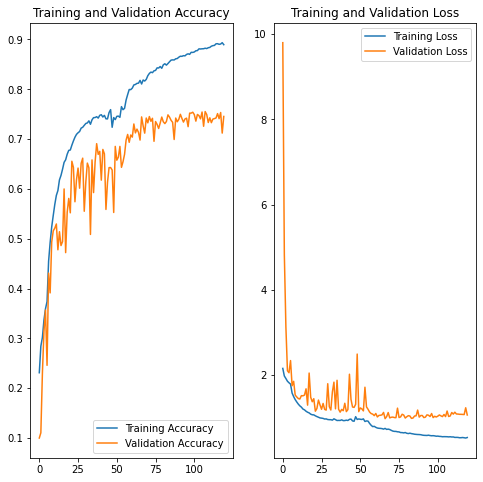

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(120)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
print(model.model(trainIm).summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
stage (stage)                (None, 16, 16, 48)        1728      
_________________________________________________________________
stage_1 (stage)              (None, 8, 8, 48)          46464     
_________________________________________________________________
stage_2 (stage)              (None, 4, 4, 96)          139008    
_________________________________________________________________
stage_3 (stage)              (None, 2, 2, 192)         554496    
_________________________________________________________________
stage_4 (stage)              (None, 1, 1, 1280)        246528